<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/ELM%20Approach/ELM_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

activation = 'tanh'
jml_units = int(48)
klaster = 0
jml_bln = 1

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
random.seed(1)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
np.random.seed(1)
np.random.RandomState(1)
# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1)
# line below wrapped all three commands above into a single one
tf.keras.utils.set_random_seed(1)

# Preparing Data

In [ ]:
import pickle

# trying open dataset
pickle_in_tr_0 =open(f"/content/drive/MyDrive/Renald/Preprosessing_data/Data_Train_{klaster}_3D.pickle",'rb')
Xtrain = pickle.load(pickle_in_tr_0)

pickle_in_val_0 =open(f"/content/drive/MyDrive/Renald/Preprosessing_data/Data_Val_{klaster}_3D.pickle",'rb')
Xval = pickle.load(pickle_in_val_0)

pickle_in_ts_0 =open(f"/content/drive/MyDrive/Renald/Preprosessing_data/Data_Test_{klaster}_3D.pickle",'rb')
Xtest = pickle.load(pickle_in_ts_0)

# print(Xtrain_0)
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(288, 779, 9)
(96, 779, 9)
(96, 779, 9)


## Transposing Dimension

In [ ]:
import numpy as np

Xtrain = np.transpose(Xtrain, (1, 0, 2))
Xval = np.transpose(Xval, (1, 0, 2))
Xtest = np.transpose(Xtest, (1, 0, 2))

print('train',np.shape(Xtrain))
print('val',np.shape(Xval))
print('test',np.shape(Xtest))

train (779, 288, 9)
val (779, 96, 9)
test (779, 96, 9)


## Timelag Transform

In [ ]:
def TimeLagTransform(data, past_time):
  cols = data.columns
  for i in reversed(range(past_time)):
    for j in cols:
      data['%s(t-%d)'%(j,i+1)] = data[j].shift(periods=i)
  return data

past_time = jml_bln
np_data = []

for i in range(len(Xtrain)):
  # assigning data into pandas
  xtrain = pd.DataFrame(Xtrain[i])
  xval = pd.DataFrame(Xval[i])
  xtest = pd.DataFrame(Xtest[i])
  # merging all data into one
  xdata = pd.concat([xtrain,xval,xtest])
  # generating target column
  xdata[str(len(xdata.columns))] = xdata[round(len(xdata.columns)/2)].shift(periods=-1)
  data = xdata.drop(columns=str(len(xdata.columns)-1))
  # transforming timelag
  data = TimeLagTransform(data=data.copy(), past_time=past_time).drop(columns=data.columns, axis=1)
  data[str(len(data.columns))]=xdata.iloc[:,-1]
  data.dropna(inplace=True)
  np_data.append(data.values)

np_data = np.array(np_data)

print('data:',np.shape(np_data))

data: (779, 479, 10)


## Resplitting Data

In [ ]:
panjang = len(np_data[0])
Xtrain = []
Xval = []
Xtest = []

for i in range(len(np_data)):
  Xtrain.append(np_data[i,:round(3/5*panjang-1),:])
  Xval.append(np_data[i,round(3/5*panjang-1):round(4/5*panjang),:])
  Xtest.append(np_data[i,round(4/5*panjang):,:])

print('train',np.shape(Xtrain))
print('val',np.shape(Xval))
print('test',np.shape(Xtest))

train (779, 286, 10)
val (779, 97, 10)
test (779, 96, 10)


## Splitting Features and Target Columns

In [ ]:
Xtrain, Xval, Xtest = np.array(Xtrain), np.array(Xval), np.array(Xtest)

Xtrain, ytrain = Xtrain[:,:,:-1], Xtrain[:,:,-1]
Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1],past_time,int(Xtrain.shape[2]/past_time)))

Xval, yval = Xval[:,:,:-1], Xval[:,:,-1]
Xval = Xval.reshape((Xval.shape[0],Xval.shape[1],past_time,int(Xval.shape[2]/past_time)))

Xtest, ytest = Xtest[:,:,:-1], Xtest[:,:,-1]
Xtest = Xtest.reshape((Xtest.shape[0],Xtest.shape[1],past_time,int(Xtest.shape[2]/past_time)))

print('xtrain',np.shape(Xtrain))
print('ytrain',np.shape(ytrain))
print('xval',np.shape(Xval))
print('yval',np.shape(yval))
print('xtest',np.shape(Xtest))
print('ytest',np.shape(ytest))

xtrain (779, 286, 1, 9)
ytrain (779, 286)
xval (779, 97, 1, 9)
yval (779, 97)
xtest (779, 96, 1, 9)
ytest (779, 96)


## Flatten 

In [ ]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2]*Xtrain.shape[3])
Xval = Xval.reshape(Xval.shape[0],Xval.shape[1],Xval.shape[2]*Xval.shape[3])
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]*Xtest.shape[3])

print('train',np.shape(Xtrain))
print('val',np.shape(Xval))
print('test',np.shape(Xtest))

train (779, 286, 9)
val (779, 97, 9)
test (779, 96, 9)


## Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

xtrain = []
xval = []
xtest = []


scaler = StandardScaler()
for i in range(len(Xtrain)):
  xtrain.append(scaler.fit_transform(Xtrain[i]))
  xval.append(scaler.transform(Xval[i]))
  xtest.append(scaler.transform(Xtest[i]))

xtrain = np.array(xtrain)
xval = np.array(xval)
xtest = np.array(xtest)

print('train',np.shape(xtrain))
print('val',np.shape(xval))
print('test',np.shape(xtest))

train (779, 286, 9)
val (779, 97, 9)
test (779, 96, 9)


# Modelling

## Defining Hyperparameter

In [ ]:
input_size = xtrain.shape[-1]
hidden_size = jml_units
input_weights = np.random.normal(size=[input_size,hidden_size])
biases = np.random.normal(size=[hidden_size])
print('Input Weight shape:', input_weights.shape)

Input Weight shape: (9, 48)


## Defining Function

In [ ]:
def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def sigmoid(x):
  return 1/(1 + np.exp(-x))
def relu(x):
   return np.maximum(x, 0, x) # nanti tanya nicho
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    if activation == 'tanh': H = tanh(G)
    elif activation == 'sigmoid': H = sigmoid(G)
    else: H = relu(G)
    return H
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

## Looping

In [ ]:
from scipy import linalg
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

mulai = datetime.now()+timedelta(hours=7)

# output_weights = np.dot(linalg.pinv2(hidden_nodes(xtrain[100])), ytrain[100])

loss_mae = []
loss_mape = []
loss_rmse = []
weight_hist = []

for i in range(len(xtrain)):
  start = datetime.now()+timedelta(hours=7)
  output_weights = np.dot(linalg.pinv(hidden_nodes(xtrain[i])), ytrain[i])
  
  train_pred = predict(xtrain[i])
  val_pred = predict(xval[i])
  test_pred = predict(xtest[i])

  train_mape = mean_absolute_percentage_error(ytrain[i], train_pred)
  val_mape = mean_absolute_percentage_error(yval[i], val_pred)
  test_mape = mean_absolute_percentage_error(ytest[i], test_pred)

  train_mae = mean_absolute_error(ytrain[i], train_pred)
  val_mae = mean_absolute_error(yval[i], val_pred)
  test_mae = mean_absolute_error(ytest[i], test_pred)

  train_rmse = mean_squared_error(ytrain[i], train_pred, squared=False)
  val_rmse = mean_squared_error(yval[i], val_pred, squared=False)
  test_rmse = mean_squared_error(ytest[i], test_pred, squared=False)

  loss_mae.append([train_mae,val_mae, test_mae])
  loss_mape.append([train_mape,val_mape, test_mape])
  loss_rmse.append([train_rmse,val_rmse, test_rmse])
  weight_hist.append(output_weights)
  end = datetime.now()+timedelta(hours=7)
  print('epoch:', i+1, ' train_mape:', train_mape, 'val_mape:', val_mape, 'time: %.2f' % (end-start).total_seconds(),'seconds')

selesai = datetime.now()+timedelta(hours=7)

print('Output Weight shape:', output_weights.shape)
print('Time taken:', (selesai-mulai))

epoch: 1  train_mape: 0.371036829176187 val_mape: 0.2788464222419352 time: 0.11 seconds
epoch: 2  train_mape: 0.3606257204543991 val_mape: 0.2481978094658183 time: 0.08 seconds
epoch: 3  train_mape: 0.3767005940871918 val_mape: 0.25891183140434776 time: 0.04 seconds
epoch: 4  train_mape: 0.35105037632899455 val_mape: 0.2668600113112733 time: 0.04 seconds
epoch: 5  train_mape: 0.34462530305249406 val_mape: 0.2786506287585838 time: 0.05 seconds
epoch: 6  train_mape: 0.3483501560373435 val_mape: 0.2739549818928334 time: 0.04 seconds
epoch: 7  train_mape: 0.37545925127478186 val_mape: 0.31146997204440674 time: 0.05 seconds
epoch: 8  train_mape: 0.35267185247025323 val_mape: 0.3129294558498376 time: 0.03 seconds
epoch: 9  train_mape: 0.3800073535274568 val_mape: 0.28890309471344044 time: 0.04 seconds
epoch: 10  train_mape: 0.3780079374843258 val_mape: 0.3057234240915607 time: 0.04 seconds
epoch: 11  train_mape: 0.3682740403955377 val_mape: 0.2958151292938896 time: 0.05 seconds
epoch: 12  tr

# Evaluation

## Loading Tables

In [ ]:
df_hist = pd.read_excel(f'/content/drive/MyDrive/Rizuki/ELM/ELM-SpatioTemporal/LossResult_{klaster}_{jml_bln}.xlsx', index_col='model')
df_hist

,train16,val16,test16,train32,val32,test32,train48,val48,test48
model,,,,,,,,,
MAE-relu,80.28,78.43,75.45,75.85,79.73,78.15,73.16,82.30,84.04
MAPE-relu,0.53,0.42,0.46,0.50,0.43,0.47,0.48,0.44,0.50
RMSE-relu,100.75,99.89,94.83,95.33,102.06,98.12,92.16,105.13,127.60
MAE-sigmoid,78.95,77.13,74.34,75.84,79.37,77.90,73.03,82.56,81.87
MAPE-sigmoid,0.53,0.41,0.46,0.50,0.43,0.48,0.48,0.44,0.50
RMSE-sigmoid,98.91,98.57,93.20,95.39,101.51,97.90,92.04,105.58,103.23
MAE-tanh,80.67,78.37,75.47,76.20,79.69,78.84,72.98,81.84,81.60
MAPE-tanh,0.53,0.42,0.46,0.50,0.43,0.48,0.48,0.44,0.49
RMSE-tanh,101.06,100.66,94.50,95.81,101.80,99.10,91.85,105.01,102.90


In [ ]:
df_time = pd.read_excel(f'/content/drive/MyDrive/Rizuki/ELM/ELM-SpatioTemporal/TimeResult_{klaster}_{jml_bln}.xlsx', index_col='time')
df_time.columns = ['16','32','48']
df_time

,16,32,48
time,,,
relu,0:00:11.196236,0:00:15.902365,0:00:23.311558
sigmoid,0:00:12.998887,0:00:16.175308,0:00:26.605212
tanh,0:00:14.186096,0:00:18.772053,0:00:29.999192


In [ ]:
df_hist.loc[df_hist.index==f'MAE-{activation}', f'train{hidden_size}']

model
MAE-tanh    72.98
Name: train48, dtype: float64

## Defining Function

In [ ]:
def plot_loss(history, error, title):

    history_loss = np.array(history)
    history_split = np.hsplit(history_loss,3)
    h_train = history_split[0]
    h_val = history_split[1]
    h_test = history_split[2] 

    plt.figure(figsize=(10,6))
    plt.plot(h_train, label='Train')
    plt.plot(h_val, label='Validation')
    plt.plot(h_test, label='Test')
    plt.title(title)
    plt.xlabel('Number of Spatial')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    #time
    times = selesai-mulai
    df_time.loc[df_time.index==activation, str(hidden_size)] = str(times)

    #training
    tr_min_idx = np.argmin(h_train)
    tr_min_loss = h_train[tr_min_idx]
    print(f'Minimum training {error} of {tr_min_loss} reached at spatial {tr_min_idx}')

    tr_max_idx = np.argmax(h_train)
    tr_max_loss = h_train[tr_max_idx]
    print(f'Maximum training {error} of {tr_max_loss} reached at spatial {tr_max_idx}')

    mean_idx_training = np.mean(h_train)
    df_hist.loc[df_hist.index==f'{error}-{activation}', f'train{hidden_size}'] = mean_idx_training
    print(f'Average training {error} loss: ', mean_idx_training)
    
    #validation
    v_min_idx = np.argmin(h_val)
    v_min_loss = h_val[v_min_idx]
    print(f'Minimum validation {error} of {v_min_loss} reached at spatial {v_min_idx}')

    v_max_idx = np.argmax(h_val)
    v_max_loss = h_val[v_max_idx]
    print(f'Maximum validation {error} of {v_max_loss} reached at spatial {v_max_idx}')

    mean_idx_val = np.mean(h_val)
    df_hist.loc[df_hist.index==f'{error}-{activation}', f'val{hidden_size}'] = mean_idx_val
    print(f'Average validation {error} loss: ', mean_idx_val)

    #test
    test_min_idx = np.argmin(h_test)
    test_min_loss = h_test[test_min_idx]
    print(f'Minimum test {error} of {test_min_loss} reached at spatial {test_min_idx}')

    test_max_idx = np.argmax(h_test)
    test_max_loss = h_test[test_max_idx]
    print(f'Maximum test {error} of {test_max_loss} reached at spatial {test_max_idx}')

    mean_idx_test = np.mean(h_test)
    df_hist.loc[df_hist.index==f'{error}-{activation}', f'test{hidden_size}'] = mean_idx_test
    print(f'Average test {error} loss: ', mean_idx_test)

## Plotting Histories

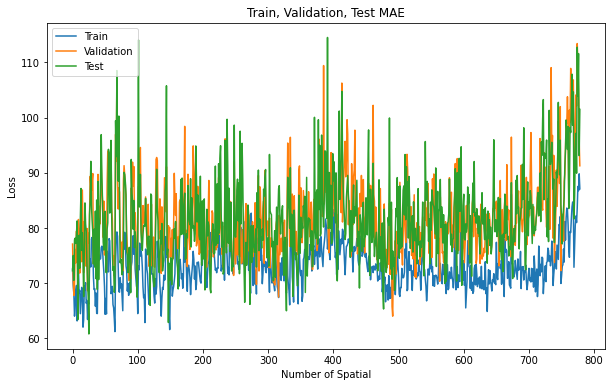

Minimum training MAE of [61.22432136] reached at spatial 65
Maximum training MAE of [89.82065368] reached at spatial 777
Average training MAE loss:  72.97589809516305
Minimum validation MAE of [64.02828124] reached at spatial 491
Maximum validation MAE of [113.43473386] reached at spatial 774
Average validation MAE loss:  81.83844616055177
Minimum test MAE of [60.80073424] reached at spatial 25
Maximum test MAE of [114.53652213] reached at spatial 391
Average test MAE loss:  81.5987255409487


In [ ]:
plot_loss(loss_mae, 'MAE','Train, Validation, Test MAE')

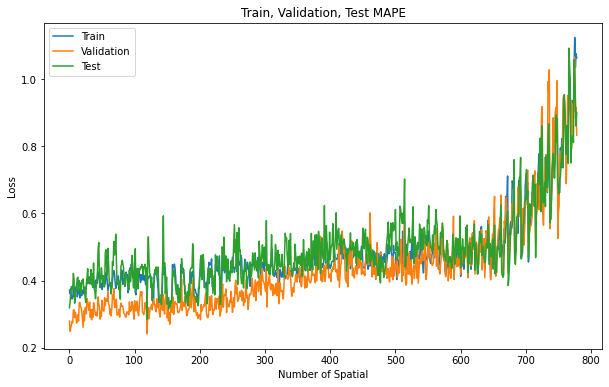

Minimum training MAPE of [0.32849133] reached at spatial 153
Maximum training MAPE of [1.12541176] reached at spatial 775
Average training MAPE loss:  0.477522441739958
Minimum validation MAPE of [0.24040691] reached at spatial 119
Maximum validation MAPE of [1.06663095] reached at spatial 775
Average validation MAPE loss:  0.4380368342668468
Minimum test MAPE of [0.28450104] reached at spatial 119
Maximum test MAPE of [1.09352512] reached at spatial 766
Average test MAPE loss:  0.49146954320853997


In [ ]:
plot_loss(loss_mape, 'MAPE','Train, Validation, Test MAPE')

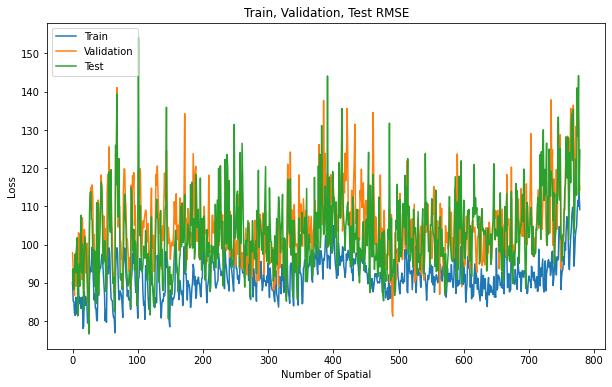

Minimum training RMSE of [76.96082181] reached at spatial 65
Maximum training RMSE of [112.85257646] reached at spatial 777
Average training RMSE loss:  91.84649360437778
Minimum validation RMSE of [81.29380152] reached at spatial 491
Maximum validation RMSE of [141.07941093] reached at spatial 68
Average validation RMSE loss:  105.00918805656453
Minimum test RMSE of [76.64787448] reached at spatial 25
Maximum test RMSE of [154.1867456] reached at spatial 101
Average test RMSE loss:  102.90438737715857


In [ ]:
plot_loss(loss_rmse, 'RMSE','Train, Validation, Test RMSE')

## Saving Tables

In [ ]:
df_hist = df_hist.round(2)
df_hist.to_excel(f'/content/drive/MyDrive/Rizuki/ELM/ELM-SpatioTemporal/LossResult_{klaster}_{jml_bln}.xlsx')
df_hist

,train16,val16,test16,train32,val32,test32,train48,val48,test48
model,,,,,,,,,
MAE-relu,80.28,78.43,75.45,75.85,79.73,78.15,73.16,82.30,84.04
MAPE-relu,0.53,0.42,0.46,0.50,0.43,0.47,0.48,0.44,0.50
RMSE-relu,100.75,99.89,94.83,95.33,102.06,98.12,92.16,105.13,127.60
MAE-sigmoid,78.95,77.13,74.34,75.84,79.37,77.90,73.03,82.56,81.87
MAPE-sigmoid,0.53,0.41,0.46,0.50,0.43,0.48,0.48,0.44,0.50
RMSE-sigmoid,98.91,98.57,93.20,95.39,101.51,97.90,92.04,105.58,103.23
MAE-tanh,80.67,78.37,75.47,76.20,79.69,78.84,72.98,81.84,81.60
MAPE-tanh,0.53,0.42,0.46,0.50,0.43,0.48,0.48,0.44,0.49
RMSE-tanh,101.06,100.66,94.50,95.81,101.80,99.10,91.85,105.01,102.90


In [ ]:
df_time.to_excel(f'/content/drive/MyDrive/Rizuki/ELM/ELM-SpatioTemporal/TimeResult_{klaster}_{jml_bln}.xlsx')
df_time

,16,32,48
time,,,
relu,0:00:11.196236,0:00:15.902365,0:00:23.311558
sigmoid,0:00:12.998887,0:00:16.175308,0:00:26.605212
tanh,0:00:14.186096,0:00:18.772053,0:00:33.226347
